# 11. Linear Regression

## 11.7 Bayesian linear regression

### 11.7.5 The advantage of centering

> Illustrate benefits of centering data for reducing correlation between slope and intercept for 1d regression
>
> Based on https://github.com/aloctavodia/BAP/blob/master/code/Chp3/03_Modeling%20with%20Linear%20Regressions.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng()

N = 100

α = 2.5
β = 0.9
σ = 0.5

X = rng.normal(loc=10, scale=1.0, size=N)
ε = rng.normal(scale=σ, size=N)
y = α + β * X + ε

X.shape, y.shape

((100,), (100,))

In [3]:
%%time
import pymc as pm

# Fit posterior with MCMC instead of analytically (for simplicity and flexibility)
# This is the same as BAP code, except we fix the noise variance to a constant.
with pm.Model():
    w0 = pm.Normal('w0', mu=0, sigma=10)
    w1 = pm.Normal('w1', mu=0, sigma=1)
    mu = pm.Deterministic('mu', w0 + w1 * X)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=σ, observed=y)
    trace = pm.sample(draws=1000, cores=1, chains=2)

with pm.Model():
    w0 = pm.Normal('w0', mu=0, sigma=10)
    w1 = pm.Normal('w1', mu=0, sigma=1)
    mu = pm.Deterministic('mu', w0 + w1 * (X - X.mean()))
    y_pred = pm.Normal('y_pred', mu=mu, sigma=σ, observed=y)
    trace_centered = pm.sample(draws=1000, cores=1, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w0, w1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8878, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w0, w1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


CPU times: total: 13.3 s
Wall time: 34.2 s


In [4]:
pm.summary(trace, var_names=['w0', 'w1'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w0,2.259,0.459,1.337,3.042,0.026,0.019,304.0,264.0,1.01
w1,0.923,0.046,0.843,1.013,0.003,0.002,307.0,265.0,1.01


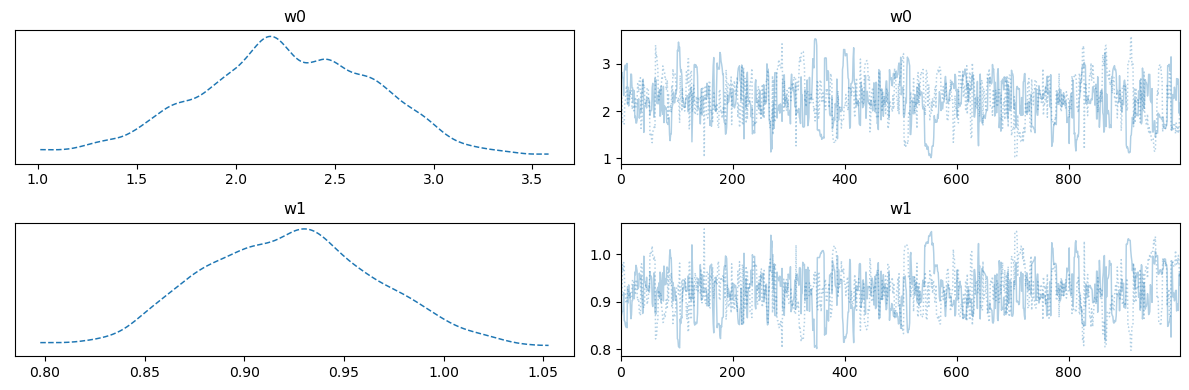

In [5]:
pm.plot_trace(
    trace, var_names=['w0', 'w1'], combined=True,
    backend_kwargs={'tight_layout': True}
);

In [6]:
pm.summary(trace_centered, var_names=['w0', 'w1'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w0,11.459,0.049,11.368,11.550,0.001,0.001,2079.0,1558.0,1.0
w1,0.920,0.048,0.833,1.012,0.001,0.001,2067.0,1329.0,1.0


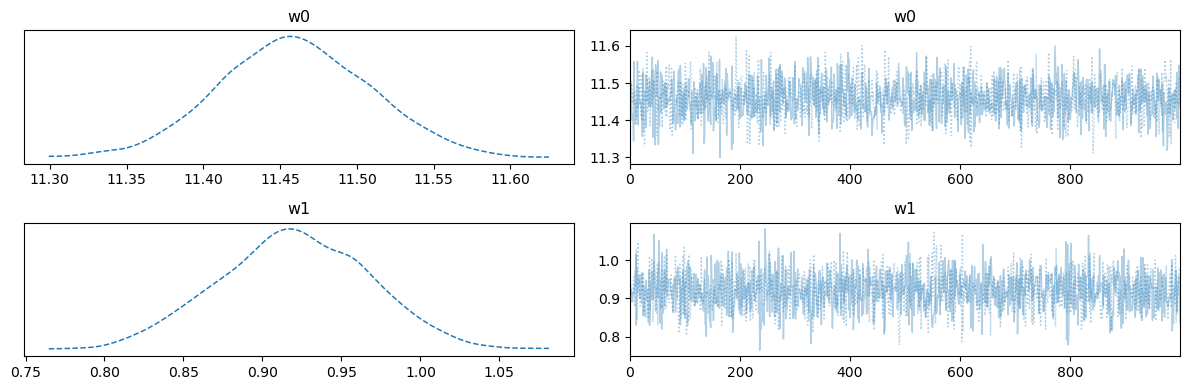

In [7]:
pm.plot_trace(
    trace_centered, var_names=['w0', 'w1'], combined=True,
    backend_kwargs={'tight_layout': True}
);

In [15]:
trace.posterior.w1.mean().values

array(0.92269058)

#### Figure 11.22: Posterior samples of $p(w|\mathcal{D})$ for 1d linear regression model $p(y|x,w)=\mathcal{N}(y|w^Tx,\sigma^2)$ with a Gaussian prior. (a) Original data. (b) Centered data.

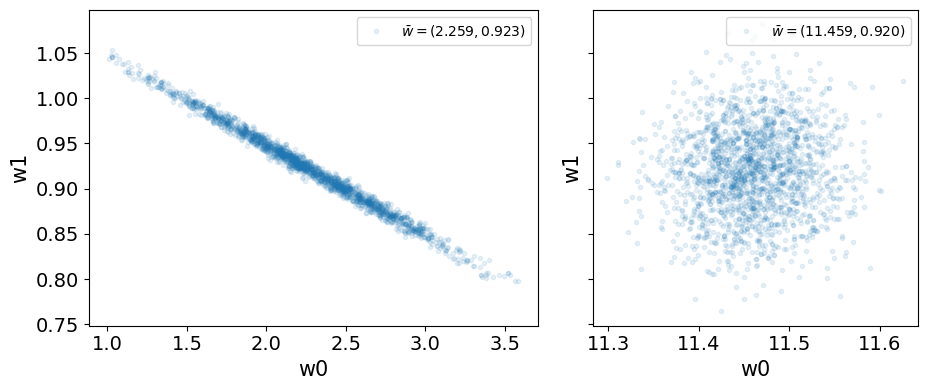

In [29]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4), sharey=True, tight_layout=True)
pm.plot_pair(
    trace, var_names=['w0', 'w1'],
    ax=ax1, scatter_kwargs={'alpha': 0.1}
)
pm.plot_pair(trace_centered, var_names=['w0', 'w1'], ax=ax2, scatter_kwargs={'alpha': 0.1})
#ax1.set_aspect('equal')
ax1.legend([
    f'$\\bar w=({trace.posterior.w0.mean():.3f},{trace.posterior.w1.mean():.3f})$'
], loc='upper right')
ax2.set_aspect('equal')
ax2.legend([
    f'$\\bar w=({trace_centered.posterior.w0.mean():.3f},{trace_centered.posterior.w1.mean():.3f})$'
], loc='upper right');

In [31]:
X.mean(), X.var()

(9.971006469548332, 1.0760224767830529)